In [237]:
from dotenv import load_dotenv
from googleapiclient.discovery import build
from youtube_transcript_api import YouTubeTranscriptApi
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_community.vectorstores import FAISS
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_core.documents import Document
from langchain_community.tools import DuckDuckGoSearchRun
from typing import TypedDict
import os
from datetime import datetime

In [238]:
# Load environment variables
load_dotenv()

# Initialize APIs
youtube = build('youtube', 'v3', developerKey=os.getenv("YOUTUBE_API_KEY"))
embedder = OpenAIEmbeddings(model="text-embedding-3-small")
llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0.7)

In [239]:
class SearchResult:
    def __init__(self, search_result):
        self.video_id = search_result['id']['videoId']
        self.title = search_result['snippet']['title']
        self.transcript = self._get_transcript()

    def _get_transcript(self):
        try:
            transcript_list = YouTubeTranscriptApi.get_transcript(self.video_id)
            return " ".join([item['text'] for item in transcript_list])
        except Exception as e:
            print(f"Transcript error for {self.video_id}: {str(e)}")
            return ""

In [240]:
def search_yt(query, max_results=3):
    try:
        request = youtube.search().list(
            part="snippet",
            maxResults=max_results,
            q=query,
            videoCaption='closedCaption',
            type='video',
        )
        return request.execute().get('items', [])
    except Exception as e:
        print(f"YouTube API error: {str(e)}")
        return []

In [241]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200
)

In [242]:
def create_faiss_index(items):
    documents = []
    for item in items:
        result = SearchResult(item)
        if not result.transcript:
            continue
            
        full_text = f"Title: {result.title}\nTranscript: {result.transcript}"
        chunks = text_splitter.split_text(full_text)
        
        for chunk in chunks:
            documents.append(Document(
                page_content=chunk,
                metadata={
                    "video_id": result.video_id,
                    "title": result.title
                }
            ))
    
    if not documents:
        print("No valid documents created")
        return None
    
    try:
        return FAISS.from_documents(documents, embedder)
    except Exception as e:
        print(f"FAISS error: {str(e)}")
        return None

In [243]:
from typing import Optional
from langchain_core.runnables import RunnableLambda

In [244]:
class State(TypedDict):
    topic: str
    author: str
    question: str
    objective_check: bool
    response_summary: str
    validate_response: str
    fact_correction: str
    generate_final_response: str

In [245]:
def process_youtube_items(items):
    documents = []
    for item in items:
        result = SearchResult(item)
        if result.transcript:
            full_text = f"Video: {result.title}\nTranscript: {result.transcript}"
            chunks = text_splitter.split_text(full_text)
            documents.extend([
                Document(
                    page_content=chunk,
                    metadata={
                        "source": "youtube",
                        "video_id": result.video_id,
                        "title": result.title
                    }
                ) for chunk in chunks
            ])
    return documents

In [246]:
class FinancialWorkflow:
    def __init__(self):
        self.combined_index: Optional[FAISS] = None  # External index storage

    from typing import List, Optional, TypedDict
    def process_ddg_results(self, results: str, state: State) -> List[Document]:
        """Convert DDG results to documents with state-aware metadata"""
        try:
            if not results.strip():
                return []
                
            return [
                Document(
                    page_content=result.strip(),
                    metadata={
                        "source": "web",
                        "search_query": f"{state['topic']} {state['author']}",
                        "timestamp": datetime.now().isoformat()
                    }
                ) for result in results.split("\n\n") if result.strip()
            ]
        except Exception as e:
            print(f"DDG processing error: {str(e)}")
            return []
        
    # 3. Modify your existing functions as class methods
    def get_topic_details(self, state:State ) -> State:
        return {
            "topic": "Rich Dad Poor Dad",
            "author": "Robert Kiyosaki",
            "question": "",
            "objective_check": False,
            "response_summary": "",
            "validate_response": "",
            "fact_correction": "",
            "generate_final_response": ""
        }

    def build_combined_index(self, state: State) -> State:
        try:
            if not self.combined_index:
                print(f"\n=== Building Index for {state['topic']} ===")
                
                # YouTube processing
                yt_items = search_yt(f"{state['topic']} {state['author']}")
                yt_docs = process_youtube_items(yt_items)
                
                # DDG processing with state
                ddg_results = DuckDuckGoSearchRun().invoke(
                    f"{state['topic']} {state['author']} recent articles/interviews"
                )
                ddg_docs = self.process_ddg_results(ddg_results, state)  # Pass state here
                
                # Combine documents
                all_docs = yt_docs + ddg_docs
                if not all_docs:
                    raise ValueError("No documents found from any source")
                    
                self.combined_index = FAISS.from_documents(all_docs, embedder)
                print(f"Index built with {len(yt_docs)} YT + {len(ddg_docs)} DDG docs")
                
            return state
        except Exception as e:
            print(f"Index build failed: {str(e)}")
            return state

    def generate_author_response(self, state: State) -> State:
        try:
            if not self.combined_index:
                raise ValueError("Index not initialized")

            print(f"\n=== Generating Response for: {state['question']} ===")
            
            # 1. Use explicit input formatting
            template = """As {author}'s clone analyzing {topic}, consider:

            Context: {context}
            
            Question: {question}
            
            Requirements:
            1. Use {author}'s signature style
            2. Reference both historical and current context
            3. Provide actionable advice
            
            Analysis:"""
            
            # 2. Fix the RAG chain structure
            rag_chain = (
                {"context": self.combined_index.as_retriever(search_kwargs={"k": 5}),
                "question": RunnablePassthrough(),
                "author": lambda _: state["author"],
                "topic": lambda _: state["topic"]} 
                | ChatPromptTemplate.from_template(template)
                | llm
                | StrOutputParser()
            )

            # # 3. Pass proper input structure
            # input_data = {
            #     "question": state["question"],
            #     "author": state["author"],
            #     "topic": state["topic"]
            # }
            
            state["response_summary"] = rag_chain.invoke(state["question"])
            print("Generated Response:", state["response_summary"][:500] + "...")  # Truncate for readability
            return state
            
        except Exception as e:
            print(f"Generation error: {str(e)}")
            state["response_summary"] = f"Error: {str(e)}"
            return state

In [247]:
from typing import Optional, TypedDict
from langgraph.graph import StateGraph

In [248]:
def get_user_question(state: State) -> State:
    return {
        **state,
        "question": "current economic condition what is the best investment?"
    }

In [249]:
def validate_user_input(state: State):
    validation_prompt = f"""**Relevance Validation Task**
    
    Author: {state['author']}
    Topic: {state['topic']}
    Question: {state['question']}

    **Rules:**
    1. Focus on financial/economic concepts for "Rich Dad Poor Dad" topics
    2. Consider {state['author']}'s known expertise
    3. Allow tangential but related concepts (e.g., assets, investments, cash flow)
    4. Reject completely unrelated topics (e.g., romance, sports, politics)

    **Examples:**
    - Topic: Assets | Question: "Is a house an asset?" → True
    - Topic: Investing | Question: "Best stocks in 2024?" → True  
    - Topic: Cash Flow | Question: "How to find true love?" → False

    **Decision:**
    Respond ONLY with 'True' or 'False'"""

    print(f"Validating: '{state['question']}' against topic: '{state['topic']}'")

    response = llm.invoke(validation_prompt).content.strip().lower()
    is_valid = response == "true"
        
    print(f"Validation result: {is_valid} | Raw response: '{response}'")
    return {"objective_check": is_valid}

In [250]:
def fact_checks(state: State):
    search = DuckDuckGoSearchRun()
    search_query = ""

    # Determine search terms
    if "SEARCH:" in state["validate_response"]:
        # Extract specific search terms
        search_terms = state["validate_response"].split("SEARCH:")[-1].strip()
        search_query = f"{state['author']} {search_terms}"
        print(f"🔍 Using validation feedback terms: {search_terms}")

    # Execute search
    results = search.invoke(search_query)
    
    # Store results with fallback
    state["fact_correction"] = results[:1000] if results else "No additional information found"
    
    return state

In [251]:
import re 

def validate_facts(state: State):
    print(f"\n=== Validating response for '{state['question']}' ===")
        
    feedback_prompt = f"""**Validation Task: Summary Quality Check**

    [Author] {state['author']}
    [Topic] {state['topic']}
    [User Question] {state['question']}

    [Quality Criteria]
    1. Directly answers the specific question asked
    2. Uses {state['author']}'s signature communication style
    3. Contains concrete examples/data from source material
    4. Acknowledges limitations when information is missing

    [Summary to Validate]
    {state['response_summary']}

    [Validation Rules]
    - Respond "VALID" if all criteria are met
    - Respond "SEARCH FOR CONTENT: [Topic Area] - [Author] - [Specific Need]" if:
        * Missing key question aspects
        * Contains generic/non-specific information
        * Lacks author-style analysis

    [Examples]
    Good Response: VALID
    Needs Improvement: SEARCH FOR CONTENT: real estate investing - Robert Kiyosaki - 2024 market trends"""

    response = llm.invoke(feedback_prompt).content.strip()
    print(f"Raw validation response: {response}")

    # Process response
    if "VALID" in response.upper():
        state["validate_response"] = "VALID"
        print("hi",state["validate_response"])
    else:
        # Extract and clean search terms
        search_terms = re.search(r"SEARCH FOR CONTENT: (.+)", response, re.IGNORECASE)
        clean_terms = re.sub(r'[^a-zA-Z0-9\s\-,:]', '', search_terms.group(1))
        state["validate_response"] = f"SEARCH FOR CONTENT: {clean_terms}"

    return state

In [252]:
def consolidate_summary(state: State) -> State:
    """Generate final summary combining verified sources with error handling"""
    try:
        print("consolidate_summary")
        # Handle failed objective check
        if not state.get("objective_check", True):
            state["generate_final_response"] = "❌ Question not relevant to the topic"
            return state

        # Determine context sources
        primary_analysis = state.get("response_summary", "")
        needs_verification = "VALID" not in state.get("validate_response", "").upper()
        external_data = state.get("fact_correction", "") if needs_verification else ""

        # Build context string conditionally
        context_sources = f"[Primary Analysis]\n{primary_analysis}"
        if external_data and "No additional information" not in external_data:
            context_sources += f"\n\n[External Verification]\n{external_data}"

        # Create dynamic prompt
        prompt = f"""As {state['author']}'s analytical clone, synthesize this response:

        {context_sources}

        [User Question] {state['question']}

        Requirements:
        1. {"Acknowledge information limits" if needs_verification else "Provide definitive analysis"}
        2. Maintain {state['author']}'s signature style
        3. Focus on practical {state['topic']} applications
        4. {"Highlight verified external data" if external_data else ""}
        5. Keep under 500 words

        Structured Analysis:"""
        
        state["generate_final_response"] = llm.invoke(prompt).content
        return state

    except Exception as e:
        print(f"Consolidation error: {str(e)}")
        state["generate_final_response"] = "Error generating final analysis"
        return state

In [253]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph,END
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from typing_extensions import TypedDict

In [254]:
def route_input(state: State):
    """
    Route the input to the appropriate tool based on the input status"""

    if state["objective_check"] == True:
        print("Accepted")
        return "Accepted"
    elif state["objective_check"] == False:
        print("Rejected")
        return "Rejected"

In [255]:
def route_basedon_Summary(state: dict):
    """
    Route the input to the appropriate tool based on the input status
    """
    validate_summary = state.get("validate_response", "")

    if validate_summary == "VALID":
        print("Accepted")
        return "Accepted"
    else: "SEARCH" in validate_summary
    print("need more info")
    return "need more info"

In [256]:
workflow = FinancialWorkflow()
builder = StateGraph(State)

# 5. Register methods as nodes
builder.add_node("get_topic", workflow.get_topic_details)
builder.add_node("content_prep", workflow.build_combined_index)
builder.add_node("get_user_question", get_user_question)
builder.add_node("validate_user_input", validate_user_input)
builder.add_node("generate_author_response", workflow.generate_author_response)
builder.add_node("validate_author_response", validate_facts)
builder.add_node("additional_facts", fact_checks)
builder.add_node("consolidate_author_response", consolidate_summary)

# 6. Keep your existing edge setup
builder.add_edge(START, "get_topic")
builder.add_edge("get_topic", "content_prep")
builder.add_edge("content_prep", "get_user_question")
builder.add_edge("get_user_question", "validate_user_input")
builder.add_edge("generate_author_response", "validate_author_response")
builder.add_edge("additional_facts", "consolidate_author_response")
builder.add_edge("consolidate_author_response", END)

# Conditional edges remain unchanged
builder.add_conditional_edges(
    "validate_user_input",
    route_input,
    {"Accepted": "generate_author_response", "Rejected": "consolidate_author_response"}
)

builder.add_conditional_edges(
    "validate_author_response",
    route_basedon_Summary,
    {"Accepted": "consolidate_author_response", "need more info": "additional_facts"}
)

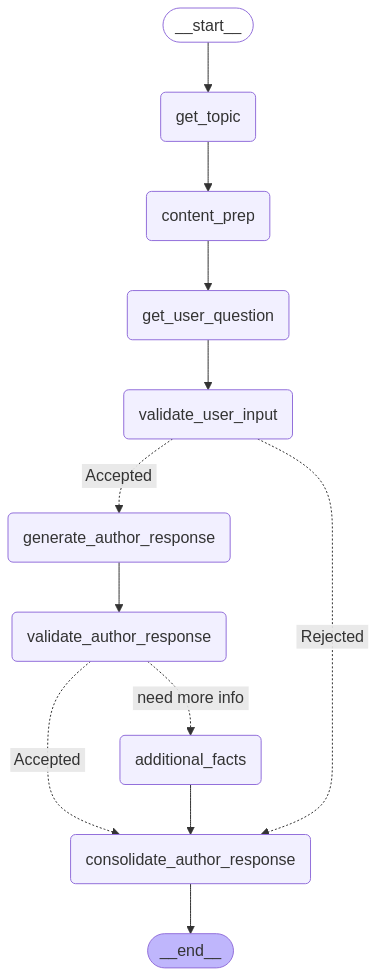

In [257]:
graph = builder.compile()
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
workflow_graph = builder.compile()
state = workflow.get_topic_details({})
state = get_user_question({})
final_state = workflow_graph.invoke(state)



=== Building Index for Rich Dad Poor Dad ===
Index built with 410 YT + 1 DDG docs
Validating: 'current economic condition what is the best investment?' against topic: 'Rich Dad Poor Dad'
Validation result: True | Raw response: 'true'
Accepted

=== Generating Response for: current economic condition what is the best investment? ===
Generated Response: In the current economic condition, the best investment is not found in following the crowd or playing it safe with traditional advice like saving money every month. As my mentor Rich Dad taught me, true wealth building requires the courage to think differently and seize opportunities that others may overlook.

Looking back at the early 1990s when the economy of Phoenix, Arizona was struggling, I witnessed firsthand how a financial planner advised people to save money diligently for 40 years to b...

=== Validating response for 'current economic condition what is the best investment?' ===
Raw validation response: VALID
hi VALID
Accepted
co

In [259]:
from IPython.display import Markdown
Markdown(final_state ['generate_final_response'])

In the current economic climate, the best investment strategy is not to follow the conventional wisdom of saving money diligently for decades. Rather, true wealth building requires thinking differently and seizing overlooked opportunities, as my mentor Rich Dad taught me.

Reflecting on the 1990s recession in Phoenix, Arizona, I observed how a financial planner advised people to save for 40 years to become wealthy. While saving is wise, it can limit one's vision and prevent them from recognizing more profitable chances for growth.

At that time, while many rushed to the stock market, I saw undervalued properties being overlooked by others. By taking advantage of this situation, I could secure valuable assets at discounted prices, showcasing the power of unconventional thinking in investing.

Today, similar opportunities abound for those willing to step out of their comfort zones and explore non-traditional investments. To succeed, one must remain vigilant, continually educate themselves, and enhance their financial intelligence to identify these opportunities when they arise.

Therefore, in the current economic landscape, the best investment lies in being bold, informed, and ready to take calculated risks when others hesitate. By daring to go against the mainstream and capitalizing on overlooked opportunities, one can achieve significant profits. Embrace creativity, stay alert, and be prepared to act decisively when the right moment presents itself.

In conclusion, the key to successful investing in the current economic climate is to think outside the box, stay informed, and be willing to take strategic risks. By embodying the principles of Rich Dad Poor Dad and embracing unconventional strategies, individuals can pave their way to financial success.